In [1]:
import tensorflow as tf
from flows import NormalRW, DFlow, ResFlow, NVPFlow, phase, Normal, floatX, MVNormal, MVNormalRW, Linear, CFlow, LinearChol
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.contrib.distributions import WishartCholesky

np.random.seed(1234)

In [2]:
data = pd.read_csv('./data/test_rus_data.csv').values.astype(floatX).T[np.newaxis][:,2:]/100

In [3]:
stds = (data[0,1:] - data[0,:-1]).std(axis=0)
print(stds)
data /= stds

[0.21742282 0.16835931 0.01139835]


In [4]:
xs = data

In [5]:
n = data.shape[1]
s1 = 0.01
s0 = 2.
dim = [3,4]

k = dim[0] * dim[1]
# with tf.variable_scope('pwalk_inf', reuse=tf.AUTO_REUSE):
#     lowerd = DFlow([Linear(dim=k*(k-1)//2 + k, name='lowerd_flow')])
#     ldiag = DFlow([NVPFlow(dim=k, name='lowerd_flow_' + str(i)) for i in range(4)])
# PWalk = MVNormalRW(dim[0]*dim[1], sigma=s1, sigma0=s0, name='param_walk_prior', 
#                    lowerd=lowerd.output[0], ldiag=ldiag.output[0]+np.log(1/s1))
PWalk = MVNormalRW(dim[0]*dim[1], sigma=s1, sigma0=s0, name='param_walk_prior')

In [6]:
def autoregr_tf(X, param):
    d = param[:,:dim[-1]-1]
    X = tf.matmul(X, d) + param[:,-1][np.newaxis]
    return X

In [7]:
def create_step_flow(name=None, prev_flow_output=None, init_sigma=1.):
    with tf.variable_scope(name, reuse=False):
        
        if prev_flow_output is not None:
            aux_vars = prev_flow_output
        else:
            aux_vars = None
            
        step_flow = DFlow([LinearChol(dim=dim[0]*dim[1], name='lc', aux_vars=aux_vars)], 
                          init_sigma=init_sigma)
    return step_flow

In [8]:
flows = [create_step_flow('step_flow0', init_sigma=s0)]
outputs = [flows[-1].output]
for i in range(n-1):
    if i >= 1:
        aux = tf.concat([outputs[-1], outputs[-2]], 1)
    else:
        aux = outputs[-1]
    new = create_step_flow('step_flow' + str(i+1), aux, init_sigma=s1)
    flows.append(new)
    outputs.append(outputs[-1] + new.output)

In [9]:
outputs = tf.concat(outputs, axis=0)[tf.newaxis]

In [10]:
outputs

<tf.Tensor 'strided_slice:0' shape=(1, 20, 12) dtype=float64>

In [11]:
prior = PWalk.logdens(outputs)

In [12]:
prior

<tf.Tensor 'param_walk_prior_2/logdens/add:0' shape=() dtype=float64>

In [13]:
def create_loglik2():
    obs_d = Normal(dim=None, sigma=1., mu=0)
    out = tf.reshape(outputs, [n, dim[0], dim[1]])
    
    def step1(current):
        X = current[0][np.newaxis]
        param = current[1]
        d = param[:,:dim[-1]-1]
        X = tf.matmul(X, d)[0] + param[:,-1]
        return X
    
    ar = tf.map_fn(step1, (xs[0][:-1], out[:-1]), dtype=tf.float64)
    return obs_d.logdens(ar - xs[0][1:])

In [14]:
logl = create_loglik2()

In [15]:
ent = tf.reduce_sum([flow.logdens for flow in flows])

In [16]:
ent

<tf.Tensor 'Sum_1:0' shape=() dtype=float64>

In [17]:
# df = dim[0]*dim[1]*10
# pmat = np.diag([(1/s1**2)]*(dim[0]*dim[1]))/df
# cov_prior = WishartCholesky(df, pmat, cholesky_input_output_matrices=True)

In [18]:
loss = -logl - prior + ent# - cov_prior.log_prob(PWalk.fsigma) + lowerd.logdens + ldiag.logdens
loss /= n*dim[0]*dim[1]

In [19]:
tf.summary.scalar('loss', loss)

<tf.Tensor 'loss:0' shape=() dtype=string>

In [20]:
opt = tf.train.AdamOptimizer(0.0001).minimize(loss)

In [21]:
sess = tf.InteractiveSession()

In [22]:
tf.global_variables_initializer().run()

In [23]:
prior.eval(), ent.eval(), logl.eval()

(-9019.362541434572, 689.6864984435347, -3745.930937130927)

In [24]:
loss.eval()

124.48199983819494

In [25]:
np.set_printoptions(precision=4)

In [26]:
PWalk.inverse_sigma.eval()[:3,:3]

array([[1.0000e+04, 7.9942e+00, 5.1307e+00],
       [7.9942e+00, 1.0000e+04, 8.0872e+00],
       [5.1307e+00, 8.0872e+00, 1.0000e+04]])

In [27]:
# all_sum = tf.summary.merge_all()
# writer = tf.summary.FileWriter('/tmp/tfdbg')

In [89]:
%%time
for _ in range(50000):
    for _ in range(400):
        l, _ = sess.run([loss, opt], {phase:True})
    print(l)
    print(PWalk.inverse_sigma.eval()[:3,:3])
    print('\n')
#     writer.add_summary(all_sum.eval())

0.2928115279353527
[[558.6622   2.0261   1.3064]
 [  2.0261 637.994   -2.2281]
 [  1.3064  -2.2281 505.404 ]]


0.30809389882354715
[[562.7463   2.0635   1.3032]
 [  2.0635 635.9319  -2.254 ]
 [  1.3032  -2.254  504.2626]]


0.2935538570419384
[[563.2548   2.0248   1.268 ]
 [  2.0248 635.7469  -2.3563]
 [  1.268   -2.3563 501.9668]]


0.28188571836461995
[[561.8285   1.994    1.2335]
 [  1.994  636.1185  -2.3258]
 [  1.2335  -2.3258 501.5538]]


0.2887673401654927
[[563.0958   2.0632   1.2143]
 [  2.0632 634.2438  -2.3056]
 [  1.2143  -2.3056 497.61  ]]


0.29588229160373863
[[560.7027   2.0378   1.1549]
 [  2.0378 636.7118  -2.3247]
 [  1.1549  -2.3247 497.703 ]]


0.30071006747004225
[[558.4897   2.054    1.2262]
 [  2.054  635.3038  -2.275 ]
 [  1.2262  -2.275  499.0826]]


0.2925627365926966
[[560.6311   2.0856   1.1947]
 [  2.0856 635.1319  -2.3072]
 [  1.1947  -2.3072 497.3985]]


0.3030443280315211
[[559.3236   2.0591   1.2397]
 [  2.0591 633.6947  -2.2908]
 [  1.2397  -2.2908 4

0.2983237236262459
[[552.6221   1.9874   1.1131]
 [  1.9874 627.189   -1.8863]
 [  1.1131  -1.8863 493.665 ]]


0.2868321394777936
[[551.3666   2.0645   1.0546]
 [  2.0645 627.5622  -1.8192]
 [  1.0546  -1.8192 493.0667]]


0.2975280949895731
[[552.3127   2.0228   1.089 ]
 [  2.0228 631.7741  -1.9068]
 [  1.089   -1.9068 494.445 ]]


0.3022970673644307
[[553.5751   2.0426   1.1455]
 [  2.0426 627.9641  -1.8805]
 [  1.1455  -1.8805 494.0431]]


0.2929845038780051
[[554.7496   2.0709   1.1754]
 [  2.0709 627.6283  -1.7885]
 [  1.1754  -1.7885 493.5643]]


0.31462389643590166
[[553.3295   2.1242   1.1802]
 [  2.1242 628.7741  -1.7219]
 [  1.1802  -1.7219 494.5012]]


0.2959485937473808
[[556.4013   2.1272   1.2784]
 [  2.1272 631.8217  -1.7225]
 [  1.2784  -1.7225 493.2114]]


0.27909443530783734
[[554.9983   2.122    1.2217]
 [  2.122  632.2483  -1.7988]
 [  1.2217  -1.7988 494.5821]]


0.2841939200900195
[[557.1929   2.1666   1.1653]
 [  2.1666 632.5961  -1.7663]
 [  1.1653  -1.7663 494

0.3032644613493716
[[548.8285   1.68     1.4765]
 [  1.68   627.4185  -2.2165]
 [  1.4765  -2.2165 489.1019]]


0.29579447795522024
[[552.2952   1.6512   1.5349]
 [  1.6512 624.9578  -2.1894]
 [  1.5349  -2.1894 490.4199]]


0.2855165800359946
[[552.4315   1.6315   1.5334]
 [  1.6315 624.2543  -2.2877]
 [  1.5334  -2.2877 492.1851]]


0.2954212862641723
[[552.2671   1.6334   1.5079]
 [  1.6334 626.0647  -2.1453]
 [  1.5079  -2.1453 492.0067]]


0.30014197264471437
[[550.3621   1.6795   1.4911]
 [  1.6795 626.7034  -2.1205]
 [  1.4911  -2.1205 490.0865]]


0.28813214861868486
[[550.2532   1.6822   1.5218]
 [  1.6822 624.2568  -1.9999]
 [  1.5218  -1.9999 491.8298]]


0.30578684521932803
[[547.2062   1.7287   1.4755]
 [  1.7287 627.2968  -2.071 ]
 [  1.4755  -2.071  492.5341]]


0.29493293367688955
[[548.3999   1.7519   1.4218]
 [  1.7519 627.2766  -2.0811]
 [  1.4218  -2.0811 492.317 ]]


0.3006383218964918
[[551.9008   1.7655   1.39  ]
 [  1.7655 629.4294  -2.0697]
 [  1.39    -2.0697 

0.296172833846443
[[539.4716   2.0776   0.9791]
 [  2.0776 622.053   -1.9977]
 [  0.9791  -1.9977 487.9816]]


0.29973579318889493
[[541.0527   2.1407   0.9279]
 [  2.1407 623.2956  -2.0081]
 [  0.9279  -2.0081 486.7532]]


0.3027348022479581
[[540.9728   2.1396   0.9964]
 [  2.1396 626.121   -2.0761]
 [  0.9964  -2.0761 486.4207]]


0.28083344276517913
[[539.8007   2.1546   1.057 ]
 [  2.1546 622.7837  -2.1077]
 [  1.057   -2.1077 480.6661]]


0.29377170426275234
[[539.7129   2.144    1.0798]
 [  2.144  619.4814  -1.9926]
 [  1.0798  -1.9926 483.1684]]


0.28441346824900576
[[541.8232   2.2021   1.1752]
 [  2.2021 620.3441  -1.9383]
 [  1.1752  -1.9383 481.9458]]


0.2932761555988475
[[538.8667   2.2203   1.103 ]
 [  2.2203 619.4395  -1.9116]
 [  1.103   -1.9116 483.9214]]


0.28829618527589296
[[541.0383   2.1976   1.0445]
 [  2.1976 617.9604  -1.9247]
 [  1.0445  -1.9247 484.7497]]


0.2844568193248527
[[539.9141   2.2824   1.0446]
 [  2.2824 616.5236  -1.9612]
 [  1.0446  -1.9612 4

0.3073582379372579
[[534.3796   2.1867   0.9437]
 [  2.1867 609.5034  -2.1969]
 [  0.9437  -2.1969 467.7344]]


0.2994235948397664
[[533.4862   2.1938   0.9273]
 [  2.1938 609.4538  -2.1434]
 [  0.9273  -2.1434 470.2145]]


0.2834613910737919
[[535.2053   2.1966   0.9269]
 [  2.1966 606.7221  -2.1591]
 [  0.9269  -2.1591 468.5739]]


0.29532997841365544
[[534.7094   2.2154   0.933 ]
 [  2.2154 604.9386  -2.09  ]
 [  0.933   -2.09   469.834 ]]


0.29289351540086794
[[532.0873   2.2572   0.9756]
 [  2.2572 604.1665  -2.2068]
 [  0.9756  -2.2068 468.6268]]


0.28312612983350977
[[531.3827   2.2841   0.9881]
 [  2.2841 607.5713  -2.167 ]
 [  0.9881  -2.167  470.9892]]


0.30916888540889736
[[532.354    2.3023   0.8871]
 [  2.3023 610.1579  -2.1787]
 [  0.8871  -2.1787 468.6547]]


0.3033898636496609
[[531.8872   2.2394   0.9161]
 [  2.2394 607.6233  -2.1874]
 [  0.9161  -2.1874 473.9958]]


0.28805991768469613
[[529.709    2.233    0.8901]
 [  2.233  609.3822  -2.1689]
 [  0.8901  -2.1689 

0.3004573799726361
[[529.7007   2.0508   1.0751]
 [  2.0508 603.1     -2.4021]
 [  1.0751  -2.4021 466.757 ]]


0.2891413822116699
[[527.5755   1.9214   1.0046]
 [  1.9214 602.6481  -2.4335]
 [  1.0046  -2.4335 467.9692]]


0.30405611330449483
[[528.5192   1.8894   1.0157]
 [  1.8894 607.0484  -2.3847]
 [  1.0157  -2.3847 468.687 ]]


0.2946847854030745
[[528.3279   1.8285   1.0387]
 [  1.8285 607.7411  -2.3803]
 [  1.0387  -2.3803 469.8441]]


0.2893169484078025
[[526.5761   1.8427   1.0376]
 [  1.8427 607.3833  -2.3762]
 [  1.0376  -2.3762 468.0052]]


0.2862288628266943
[[527.5444   1.8571   1.1239]
 [  1.8571 607.7363  -2.3444]
 [  1.1239  -2.3444 467.7479]]


0.2894888442578354
[[527.6281   1.9188   1.004 ]
 [  1.9188 607.039   -2.4443]
 [  1.004   -2.4443 466.7107]]


0.28817922369823634
[[526.7502   1.8583   1.029 ]
 [  1.8583 605.0279  -2.4314]
 [  1.029   -2.4314 468.2157]]


0.2847676437392053
[[525.1126   1.8683   1.0582]
 [  1.8683 607.5716  -2.3863]
 [  1.0582  -2.3863 467

0.29140671634156756
[[520.5447   1.622    1.2006]
 [  1.622  595.7583  -2.0331]
 [  1.2006  -2.0331 464.6562]]


0.29013633875125133
[[519.3474   1.6214   1.2256]
 [  1.6214 596.3501  -2.0479]
 [  1.2256  -2.0479 466.437 ]]


0.2907390880268622
[[518.7367   1.6183   1.2282]
 [  1.6183 596.24    -2.2341]
 [  1.2282  -2.2341 466.9181]]


0.2826438991361547
[[520.9057   1.6508   1.2214]
 [  1.6508 596.619   -2.2658]
 [  1.2214  -2.2658 464.9287]]


0.2943954610165742
[[521.6778   1.6431   1.1619]
 [  1.6431 596.3759  -2.2824]
 [  1.1619  -2.2824 464.9379]]


0.2909618809757179
[[520.0812   1.7083   1.1732]
 [  1.7083 598.8669  -2.2466]
 [  1.1732  -2.2466 464.6256]]


0.3023541751327329
[[521.7721   1.7957   1.183 ]
 [  1.7957 596.0373  -2.2044]
 [  1.183   -2.2044 463.834 ]]


0.28755873409917215
[[522.4639   1.8752   1.1945]
 [  1.8752 595.7601  -2.1708]
 [  1.1945  -2.1708 463.9168]]


0.3011151541206755
[[523.2463   1.8274   1.1817]
 [  1.8274 595.0684  -2.2141]
 [  1.1817  -2.2141 46

0.293682992372342
[[518.9739   2.4349   0.8094]
 [  2.4349 594.5195  -2.4392]
 [  0.8094  -2.4392 462.2506]]


0.2948808712118444
[[519.7311   2.3918   0.7815]
 [  2.3918 593.2416  -2.3883]
 [  0.7815  -2.3883 462.8241]]


0.2963779954537889
[[522.0605   2.3736   0.8152]
 [  2.3736 594.3968  -2.3729]
 [  0.8152  -2.3729 463.2002]]


0.2940221522741664
[[523.3112   2.3293   0.7896]
 [  2.3293 596.5726  -2.4427]
 [  0.7896  -2.4427 462.7714]]


0.2862128379441863
[[519.4964   2.3324   0.7724]
 [  2.3324 593.1399  -2.4125]
 [  0.7724  -2.4125 463.7836]]


0.2996769936638446
[[518.029    2.3072   0.7671]
 [  2.3072 593.657   -2.4333]
 [  0.7671  -2.4333 463.2147]]


0.301425523847134
[[517.3846   2.3351   0.8056]
 [  2.3351 590.8563  -2.4523]
 [  0.8056  -2.4523 462.7498]]


0.29556485818368
[[517.7739   2.3733   0.812 ]
 [  2.3733 589.902   -2.3698]
 [  0.812   -2.3698 461.4714]]


0.3015306563598299
[[516.7194   2.3835   0.847 ]
 [  2.3835 592.3307  -2.259 ]
 [  0.847   -2.259  461.863 ]

0.2822120534540836
[[514.7397   2.4607   0.8673]
 [  2.4607 585.5955  -2.3821]
 [  0.8673  -2.3821 451.4891]]


0.3046670295676127
[[513.1656   2.4834   0.846 ]
 [  2.4834 585.5087  -2.3406]
 [  0.846   -2.3406 452.6784]]


0.29603070873219767
[[512.819    2.464    0.8583]
 [  2.464  586.921   -2.3798]
 [  0.8583  -2.3798 452.2928]]


0.2885491795553577
[[512.9536   2.4642   0.8771]
 [  2.4642 587.8439  -2.4247]
 [  0.8771  -2.4247 453.4249]]


0.2881759019367621
[[512.3894   2.5027   0.9291]
 [  2.5027 586.7643  -2.3501]
 [  0.9291  -2.3501 457.2255]]


0.2782947923327619
[[510.6725   2.5301   0.8895]
 [  2.5301 586.8904  -2.2651]
 [  0.8895  -2.2651 455.7207]]


0.2929467221599514
[[511.0627   2.5197   0.9814]
 [  2.5197 586.2442  -2.2399]
 [  0.9814  -2.2399 456.0246]]


0.2900539172968166
[[511.9583   2.499    0.9962]
 [  2.499  586.3346  -2.2316]
 [  0.9962  -2.2316 454.8975]]


0.28765799640999723
[[511.9903   2.4448   0.9018]
 [  2.4448 586.4541  -2.235 ]
 [  0.9018  -2.235  451

0.2964886002521711
[[512.086    2.5258   0.6227]
 [  2.5258 588.2326  -2.586 ]
 [  0.6227  -2.586  452.3886]]


0.3012533753002359
[[512.6241   2.5092   0.6419]
 [  2.5092 588.3844  -2.5599]
 [  0.6419  -2.5599 451.8626]]


0.29757063441652415
[[511.1643   2.4851   0.6222]
 [  2.4851 588.4851  -2.5277]
 [  0.6222  -2.5277 451.3622]]


0.2853414986812974
[[512.5685   2.5496   0.6175]
 [  2.5496 587.3831  -2.5407]
 [  0.6175  -2.5407 449.9343]]


0.3093245004820711
[[513.5131   2.554    0.63  ]
 [  2.554  584.4908  -2.5192]
 [  0.63    -2.5192 450.8237]]


0.2935832567305532
[[514.3032   2.4916   0.71  ]
 [  2.4916 585.2037  -2.5001]
 [  0.71    -2.5001 448.8623]]


0.29207613321970527
[[513.0145   2.5732   0.7054]
 [  2.5732 586.134   -2.5279]
 [  0.7054  -2.5279 448.7523]]


0.2942070459647591
[[511.4627   2.5556   0.6309]
 [  2.5556 585.0437  -2.5521]
 [  0.6309  -2.5521 448.6374]]


0.28732478824764507
[[509.6494   2.4814   0.6091]
 [  2.4814 585.6838  -2.5572]
 [  0.6091  -2.5572 44

0.2902504340889938
[[505.468    2.4237   1.048 ]
 [  2.4237 583.4584  -2.5857]
 [  1.048   -2.5857 442.6219]]


0.29097530939069854
[[505.0877   2.4418   1.121 ]
 [  2.4418 583.5577  -2.5813]
 [  1.121   -2.5813 443.0507]]


0.3022706902338278
[[503.193    2.4237   1.1594]
 [  2.4237 578.6971  -2.5794]
 [  1.1594  -2.5794 447.1966]]


0.29234255650784935
[[503.1298   2.4135   1.0726]
 [  2.4135 576.0421  -2.6247]
 [  1.0726  -2.6247 446.2453]]


0.2922355328316485
[[501.6989   2.3086   1.0816]
 [  2.3086 577.2872  -2.6437]
 [  1.0816  -2.6437 447.9683]]


0.284376124187119
[[501.7255   2.3237   1.0976]
 [  2.3237 581.8673  -2.6593]
 [  1.0976  -2.6593 449.4716]]


0.2970323295355996
[[501.7307   2.3189   1.038 ]
 [  2.3189 582.9976  -2.6378]
 [  1.038   -2.6378 447.9638]]


0.2898136942120649
[[500.5046   2.2895   1.1046]
 [  2.2895 580.4399  -2.5686]
 [  1.1046  -2.5686 444.3986]]


0.2875500098261481
[[503.6435   2.2887   1.1156]
 [  2.2887 578.1698  -2.5281]
 [  1.1156  -2.5281 443.

0.28840167881975515
[[501.8349   2.338    0.6146]
 [  2.338  570.4941  -3.0041]
 [  0.6146  -3.0041 439.3551]]


0.29295636162509403
[[500.3538   2.296    0.6435]
 [  2.296  572.4532  -3.0148]
 [  0.6435  -3.0148 440.9772]]


0.3009116782221741
[[499.5413   2.3009   0.6542]
 [  2.3009 571.5825  -2.9871]
 [  0.6542  -2.9871 442.4123]]


0.2946527055530055
[[498.7417   2.3607   0.6185]
 [  2.3607 572.7819  -2.9861]
 [  0.6185  -2.9861 444.6982]]


0.2923874580459971
[[499.4458   2.3515   0.663 ]
 [  2.3515 573.7254  -3.0541]
 [  0.663   -3.0541 445.2678]]


0.288302213510426
[[499.1101   2.3603   0.6344]
 [  2.3603 571.026   -3.0802]
 [  0.6344  -3.0802 442.4047]]


0.3058538098134557
[[496.0927   2.3868   0.7233]
 [  2.3868 572.3143  -3.0814]
 [  0.7233  -3.0814 443.2475]]


0.3136810755157237
[[494.8936   2.4388   0.7816]
 [  2.4388 574.5169  -3.153 ]
 [  0.7816  -3.153  441.7795]]


0.2896279598429911
[[498.9589   2.3757   0.7519]
 [  2.3757 577.3039  -3.1084]
 [  0.7519  -3.1084 442.

0.2855498280922253
[[492.5858   2.3751   1.0011]
 [  2.3751 569.6033  -3.1497]
 [  1.0011  -3.1497 436.2121]]


0.2839580536936398
[[494.4915   2.4204   0.9743]
 [  2.4204 568.8389  -3.0591]
 [  0.9743  -3.0591 437.3964]]


0.2933138787923165
[[493.1116   2.4951   1.0147]
 [  2.4951 569.2954  -3.0838]
 [  1.0147  -3.0838 434.7198]]


0.2850772923746888
[[493.9451   2.4689   1.0948]
 [  2.4689 571.0118  -3.1331]
 [  1.0948  -3.1331 437.2336]]


0.2961709765784915
[[492.7634   2.4185   1.1069]
 [  2.4185 569.5237  -3.1294]
 [  1.1069  -3.1294 437.043 ]]


0.29676043030902477
[[492.5834   2.3545   1.1055]
 [  2.3545 568.8753  -3.159 ]
 [  1.1055  -3.159  435.5265]]


0.29678011583132524
[[496.4928   2.409    1.0843]
 [  2.409  569.1197  -3.1306]
 [  1.0843  -3.1306 436.8854]]


0.30084797404872937
[[493.9823   2.3264   1.0285]
 [  2.3264 570.4548  -3.1577]
 [  1.0285  -3.1577 436.055 ]]


0.2996899917092866
[[497.037    2.3153   0.9754]
 [  2.3153 572.2879  -3.135 ]
 [  0.9754  -3.135  43

0.29462518946924615
[[490.0457   2.1161   0.8337]
 [  2.1161 565.802   -2.6678]
 [  0.8337  -2.6678 437.2693]]


0.29858086058948935
[[491.7795   2.1056   0.8546]
 [  2.1056 565.5834  -2.6889]
 [  0.8546  -2.6889 436.6977]]


0.2913187907128927
[[490.0736   2.077    0.8866]
 [  2.077  567.0534  -2.7246]
 [  0.8866  -2.7246 435.7986]]


0.28613229505281645
[[489.7749   2.0288   0.8703]
 [  2.0288 566.8905  -2.6265]
 [  0.8703  -2.6265 437.7183]]


0.29678513771028725
[[490.7697   2.0722   0.8778]
 [  2.0722 565.2452  -2.6324]
 [  0.8778  -2.6324 436.8968]]


0.30709892025396474
[[492.5703   2.0603   0.8947]
 [  2.0603 568.0008  -2.6315]
 [  0.8947  -2.6315 436.7258]]


0.3035983568363238
[[495.632    2.084    0.9149]
 [  2.084  565.5274  -2.6482]
 [  0.9149  -2.6482 435.7457]]


0.2980295137814759
[[494.872    2.0868   0.881 ]
 [  2.0868 566.5565  -2.6549]
 [  0.881   -2.6549 435.1278]]


0.292759051215288
[[492.6158   2.1093   0.9482]
 [  2.1093 565.6878  -2.6251]
 [  0.9482  -2.6251 4

0.2991125432359617
[[491.0868   1.9814   0.8161]
 [  1.9814 563.8117  -2.5752]
 [  0.8161  -2.5752 427.5406]]


0.3080071948233332
[[490.5299   1.9434   0.7226]
 [  1.9434 562.1792  -2.5878]
 [  0.7226  -2.5878 428.5599]]


0.3026273704651615
[[488.7306   1.9591   0.7117]
 [  1.9591 562.716   -2.5643]
 [  0.7117  -2.5643 429.5887]]


0.2953410088169612
[[485.7787   1.997    0.7038]
 [  1.997  561.3634  -2.5766]
 [  0.7038  -2.5766 428.1348]]


0.28245809457054916
[[487.3476   2.063    0.6762]
 [  2.063  559.144   -2.5533]
 [  0.6762  -2.5533 429.0892]]


0.28754296207188734
[[486.0364   1.9903   0.7235]
 [  1.9903 557.4359  -2.5627]
 [  0.7235  -2.5627 428.2566]]


0.29555574362020565
[[484.9476   1.9701   0.7005]
 [  1.9701 558.2003  -2.5905]
 [  0.7005  -2.5905 427.7358]]


0.304218655360719
[[484.1199   1.9051   0.708 ]
 [  1.9051 559.8366  -2.5753]
 [  0.708   -2.5753 429.0839]]


0.28428420095734147
[[482.5897   1.9419   0.6883]
 [  1.9419 561.1278  -2.6305]
 [  0.6883  -2.6305 42

0.27973578351634126
[[485.2699   2.2461   0.8391]
 [  2.2461 557.7163  -2.7398]
 [  0.8391  -2.7398 430.9236]]


0.29032459335445204
[[484.9908   2.2372   0.868 ]
 [  2.2372 559.5583  -2.8111]
 [  0.868   -2.8111 428.8807]]


0.2999292871031815
[[487.5792   2.2846   0.7955]
 [  2.2846 560.2263  -2.8406]
 [  0.7955  -2.8406 428.723 ]]


0.2899444992805248
[[485.0226   2.3049   0.7912]
 [  2.3049 561.8902  -2.8269]
 [  0.7912  -2.8269 428.9317]]


0.2952018101929847
[[485.3291   2.2935   0.8382]
 [  2.2935 561.7904  -2.8505]
 [  0.8382  -2.8505 425.6588]]


0.2836692358169567
[[486.3113   2.3155   0.8071]
 [  2.3155 558.0315  -2.8804]
 [  0.8071  -2.8804 425.81  ]]


0.2864180204584239
[[487.1336   2.3727   0.8434]
 [  2.3727 558.0508  -2.8309]
 [  0.8434  -2.8309 425.4369]]


0.2956240790237163
[[485.0936   2.3791   0.8874]
 [  2.3791 559.7664  -2.9024]
 [  0.8874  -2.9024 425.0935]]


0.2875180505638236
[[486.2782   2.3292   0.9771]
 [  2.3292 562.2867  -2.8981]
 [  0.9771  -2.8981 424

0.2922363951283072
[[483.1748   2.0644   0.7471]
 [  2.0644 553.473   -2.9378]
 [  0.7471  -2.9378 424.9828]]


0.2893537285277143
[[481.7917   2.0865   0.7744]
 [  2.0865 552.6783  -2.8715]
 [  0.7744  -2.8715 422.8421]]


0.30714951725882905
[[481.7966   2.1751   0.7732]
 [  2.1751 552.5955  -2.8654]
 [  0.7732  -2.8654 424.7383]]


0.2914661683016748
[[482.5509   2.2102   0.7498]
 [  2.2102 552.0775  -2.881 ]
 [  0.7498  -2.881  422.153 ]]


0.29128456574223827
[[483.042    2.2349   0.7877]
 [  2.2349 550.4215  -2.9047]
 [  0.7877  -2.9047 422.6396]]


0.2970194352910068
[[484.278    2.2714   0.8254]
 [  2.2714 549.5726  -2.9274]
 [  0.8254  -2.9274 422.9743]]


0.28569232651875753
[[485.8539   2.3057   0.8593]
 [  2.3057 548.1245  -2.9465]
 [  0.8593  -2.9465 420.6504]]


0.28873299906836486
[[486.0066   2.2309   0.9375]
 [  2.2309 547.9054  -2.8952]
 [  0.9375  -2.8952 421.8474]]


0.2847241621163029
[[481.6782   2.2232   0.8398]
 [  2.2232 549.9654  -2.9077]
 [  0.8398  -2.9077 4

0.29684864760570495
[[478.9435   2.4375   0.6716]
 [  2.4375 552.2778  -2.407 ]
 [  0.6716  -2.407  422.9727]]


0.2956781740741491
[[477.1366   2.4568   0.75  ]
 [  2.4568 547.2278  -2.3463]
 [  0.75    -2.3463 421.2219]]


0.2935306733001492
[[478.6686   2.347    0.7594]
 [  2.347  546.913   -2.3678]
 [  0.7594  -2.3678 420.571 ]]


0.29090464786977865
[[478.6713   2.2984   0.7471]
 [  2.2984 550.5128  -2.3626]
 [  0.7471  -2.3626 420.8032]]


0.2912043965592898
[[477.6397   2.3237   0.7217]
 [  2.3237 545.5608  -2.4186]
 [  0.7217  -2.4186 419.5467]]


0.285464653987138
[[476.4158   2.2532   0.7675]
 [  2.2532 544.8769  -2.447 ]
 [  0.7675  -2.447  419.4426]]


0.2931159680158217
[[477.9719   2.248    0.7336]
 [  2.248  544.378   -2.4418]
 [  0.7336  -2.4418 421.9415]]


0.29199064301143735
[[474.0515   2.2077   0.7698]
 [  2.2077 546.086   -2.4729]
 [  0.7698  -2.4729 420.7942]]


0.2813097897573499
[[472.1461   2.1855   0.7857]
 [  2.1855 546.2702  -2.4749]
 [  0.7857  -2.4749 419

0.289837384563756
[[473.2786   2.0769   1.1181]
 [  2.0769 551.02    -2.7544]
 [  1.1181  -2.7544 414.2131]]


0.28372786558146806
[[474.5756   2.0878   1.0912]
 [  2.0878 549.6901  -2.826 ]
 [  1.0912  -2.826  415.7875]]


0.28410388275250753
[[473.0043   2.1243   1.1193]
 [  2.1243 551.3159  -2.8449]
 [  1.1193  -2.8449 414.4904]]


0.2940185311641559
[[472.5023   2.1781   1.1135]
 [  2.1781 554.6427  -2.9106]
 [  1.1135  -2.9106 415.292 ]]


0.2807235047547105
[[469.2976   2.2273   1.1021]
 [  2.2273 550.2892  -2.897 ]
 [  1.1021  -2.897  415.7186]]


0.28338195369474545
[[470.7171   2.1665   1.0887]
 [  2.1665 550.311   -2.988 ]
 [  1.0887  -2.988  417.0168]]


0.31186429178879393
[[471.9949   2.0686   1.0749]
 [  2.0686 547.3695  -2.9756]
 [  1.0749  -2.9756 417.6616]]


0.28891862481176744
[[470.5332   2.0122   1.0578]
 [  2.0122 548.9588  -2.9898]
 [  1.0578  -2.9898 417.0568]]


0.2965376869520076
[[470.1912   2.0169   1.0128]
 [  2.0169 548.3605  -2.9331]
 [  1.0128  -2.9331 4

0.28718911667644137
[[468.6379   2.199    0.988 ]
 [  2.199  542.9175  -3.3867]
 [  0.988   -3.3867 409.4004]]


0.2900271506945908
[[468.8935   2.2585   0.9345]
 [  2.2585 542.6293  -3.437 ]
 [  0.9345  -3.437  409.612 ]]


0.300628165556364
[[464.682    2.2658   0.8479]
 [  2.2658 544.9768  -3.4347]
 [  0.8479  -3.4347 410.9562]]


0.2941375629618702
[[466.654    2.2842   0.8988]
 [  2.2842 543.7537  -3.4067]
 [  0.8988  -3.4067 410.2088]]


0.28469230503026494
[[467.5109   2.301    0.8959]
 [  2.301  541.6298  -3.3408]
 [  0.8959  -3.3408 411.7644]]


0.29198175509747465
[[468.5134   2.2232   0.9136]
 [  2.2232 543.914   -3.418 ]
 [  0.9136  -3.418  412.0584]]


0.2935910055635998
[[471.176    2.1544   0.9206]
 [  2.1544 544.0513  -3.3183]
 [  0.9206  -3.3183 409.9946]]


0.2814436308389162
[[472.8312   2.1644   0.8165]
 [  2.1644 542.2556  -3.3202]
 [  0.8165  -3.3202 409.4384]]


0.2882270115664395
[[472.7242   2.1627   0.9039]
 [  2.1627 544.1647  -3.3115]
 [  0.9039  -3.3115 408

0.2872268434153412
[[464.5758   2.5276   0.8466]
 [  2.5276 538.2804  -3.0771]
 [  0.8466  -3.0771 409.357 ]]


0.2818663033364731
[[466.8628   2.497    0.8197]
 [  2.497  538.2957  -3.0926]
 [  0.8197  -3.0926 409.635 ]]


0.30248310081950225
[[468.0321   2.4785   0.9082]
 [  2.4785 535.4336  -3.1105]
 [  0.9082  -3.1105 408.0454]]


0.29778198293955543
[[467.6921   2.4556   0.8133]
 [  2.4556 534.0763  -3.1232]
 [  0.8133  -3.1232 408.3806]]


0.28595723834941583
[[471.5595   2.4118   0.7835]
 [  2.4118 534.0631  -3.1292]
 [  0.7835  -3.1292 408.6682]]


0.29713079504783313
[[467.9047   2.442    0.7351]
 [  2.442  537.205   -3.1194]
 [  0.7351  -3.1194 409.2995]]


0.2945444884126675
[[469.6837   2.4112   0.744 ]
 [  2.4112 539.1994  -3.1144]
 [  0.744   -3.1144 412.3116]]


0.2955066034689959
[[466.2971   2.389    0.7247]
 [  2.389  539.1912  -3.0612]
 [  0.7247  -3.0612 411.1897]]


0.2975155083102796
[[465.1907   2.3233   0.7352]
 [  2.3233 542.9851  -3.0364]
 [  0.7352  -3.0364 4

0.2953831833181084
[[466.2076   2.0256   1.0171]
 [  2.0256 537.8894  -2.7661]
 [  1.0171  -2.7661 406.0721]]


0.28303878059761256
[[467.8373   1.9776   1.0454]
 [  1.9776 538.4724  -2.7482]
 [  1.0454  -2.7482 408.6667]]


0.2916419995665812
[[465.9478   1.9747   1.0243]
 [  1.9747 536.2333  -2.7463]
 [  1.0243  -2.7463 407.1169]]


0.30696878589274307
[[465.3944   1.9317   0.9714]
 [  1.9317 536.8402  -2.7574]
 [  0.9714  -2.7574 410.2324]]


0.29790222763374385
[[465.9707   1.911    0.9961]
 [  1.911  536.5339  -2.7488]
 [  0.9961  -2.7488 409.5901]]


0.28517989945142663
[[464.7335   1.9566   0.9509]
 [  1.9566 535.9506  -2.6723]
 [  0.9509  -2.6723 408.8118]]


0.2867547173529147
[[462.4542   1.8989   0.8937]
 [  1.8989 536.7347  -2.6662]
 [  0.8937  -2.6662 408.7392]]


0.2942671600006925
[[462.0794   1.8747   0.9271]
 [  1.8747 534.7052  -2.7247]
 [  0.9271  -2.7247 407.6444]]


0.289352954925329
[[461.4695   1.7967   0.8997]
 [  1.7967 534.6578  -2.7893]
 [  0.8997  -2.7893 40

0.30046057465207454
[[465.2028   1.9649   0.9415]
 [  1.9649 530.5331  -3.0319]
 [  0.9415  -3.0319 398.9638]]


0.2741449152458178
[[465.3035   1.8947   0.9582]
 [  1.8947 530.3498  -3.1476]
 [  0.9582  -3.1476 397.187 ]]


0.2926031994367425
[[464.4606   1.9002   0.9093]
 [  1.9002 528.9885  -3.1955]
 [  0.9093  -3.1955 396.4371]]


0.2974906762549824
[[462.5438   2.0059   0.9571]
 [  2.0059 528.7544  -3.2328]
 [  0.9571  -3.2328 401.3344]]


0.2914101335359182
[[462.7436   2.0448   0.9427]
 [  2.0448 531.6738  -3.1939]
 [  0.9427  -3.1939 399.0093]]


0.28735988266742896
[[461.5702   1.992    0.8693]
 [  1.992  533.1421  -3.1221]
 [  0.8693  -3.1221 400.2012]]


0.29115441675550335
[[463.1101   1.9831   0.9263]
 [  1.9831 530.6968  -3.0377]
 [  0.9263  -3.0377 402.1217]]


0.28001650471358347
[[464.906    2.0071   0.9479]
 [  2.0071 529.6791  -3.0332]
 [  0.9479  -3.0332 400.8854]]


0.30359495964214034
[[462.4495   2.0599   0.9288]
 [  2.0599 532.6899  -3.0633]
 [  0.9288  -3.0633 

0.2940687050937901
[[454.329    1.6712   0.9717]
 [  1.6712 531.2171  -3.182 ]
 [  0.9717  -3.182  395.9588]]


0.30133637315049244
[[453.5272   1.6706   1.0341]
 [  1.6706 526.0971  -3.1839]
 [  1.0341  -3.1839 398.6096]]


0.2968078802236436
[[454.9327   1.6835   1.0421]
 [  1.6835 528.7401  -3.2548]
 [  1.0421  -3.2548 398.3101]]


0.29250780079753913
[[456.36     1.6877   1.06  ]
 [  1.6877 530.0928  -3.1921]
 [  1.06    -3.1921 398.1584]]


0.30887464201991555
[[455.279    1.7475   1.0339]
 [  1.7475 524.6551  -3.1843]
 [  1.0339  -3.1843 396.9205]]


0.2919960726306189
[[452.7807   1.7723   0.9605]
 [  1.7723 525.723   -3.2   ]
 [  0.9605  -3.2    396.0787]]


0.2836170224973427
[[452.7384   1.826    0.9311]
 [  1.826  529.0537  -3.175 ]
 [  0.9311  -3.175  396.4717]]


0.3074913552160936
[[454.8097   1.8325   0.8155]
 [  1.8325 525.9241  -3.1863]
 [  0.8155  -3.1863 399.0699]]


0.2944101774310859
[[455.8304   1.7586   0.8371]
 [  1.7586 527.1268  -3.1608]
 [  0.8371  -3.1608 39

0.28575750063761235
[[453.4019   2.254    1.2283]
 [  2.254  525.2619  -3.1326]
 [  1.2283  -3.1326 391.5811]]


0.30615029599954485
[[453.4835   2.2716   1.2123]
 [  2.2716 526.4446  -3.0824]
 [  1.2123  -3.0824 391.4184]]


0.2970444809241381
[[453.3751   2.2475   1.2653]
 [  2.2475 525.2216  -3.0612]
 [  1.2653  -3.0612 393.0755]]


0.2862051400774514
[[454.4946   2.2414   1.2717]
 [  2.2414 526.0285  -2.9964]
 [  1.2717  -2.9964 394.1809]]


0.2781309497583656
[[453.7309   2.2222   1.1926]
 [  2.2222 525.855   -3.0061]
 [  1.1926  -3.0061 395.398 ]]


0.3049782817100642
[[456.7184   2.243    1.1398]
 [  2.243  529.3763  -3.0538]
 [  1.1398  -3.0538 394.8459]]


0.299952085822297
[[457.602    2.2116   1.1945]
 [  2.2116 525.6774  -3.0785]
 [  1.1945  -3.0785 395.5395]]


0.2968845201959674
[[456.5222   2.2699   1.201 ]
 [  2.2699 525.3295  -3.0753]
 [  1.201   -3.0753 397.0169]]


0.29297026389647013
[[455.1545   2.2759   1.227 ]
 [  2.2759 526.1625  -3.1074]
 [  1.227   -3.1074 393

0.29559330147286833
[[448.7634   2.0773   1.3281]
 [  2.0773 521.5104  -3.1177]
 [  1.3281  -3.1177 394.1928]]


0.28894605599322293
[[452.5261   2.1179   1.3772]
 [  2.1179 520.8201  -3.0063]
 [  1.3772  -3.0063 394.5721]]


0.29144738979133916
[[454.5666   2.1022   1.3465]
 [  2.1022 521.4953  -3.012 ]
 [  1.3465  -3.012  394.7259]]


0.2961851130493088
[[451.6421   2.0772   1.3138]
 [  2.0772 523.2354  -2.9955]
 [  1.3138  -2.9955 394.5167]]


0.28686488758545464
[[450.1894   2.0896   1.3072]
 [  2.0896 523.3538  -3.0021]
 [  1.3072  -3.0021 395.4224]]


0.2966957262189401
[[450.4308   2.0903   1.2471]
 [  2.0903 524.0032  -3.0577]
 [  1.2471  -3.0577 392.4476]]


0.2998279614417093
[[451.7574   2.055    1.2843]
 [  2.055  522.9949  -3.098 ]
 [  1.2843  -3.098  390.4551]]


0.30829365667567193
[[450.8852   2.0933   1.2922]
 [  2.0933 523.8587  -3.1407]
 [  1.2922  -3.1407 390.1111]]


0.2970901978710638
[[449.041    2.1104   1.283 ]
 [  2.1104 520.812   -3.1179]
 [  1.283   -3.1179 

0.3072764928263946
[[448.9523   2.5254   1.0707]
 [  2.5254 521.9375  -3.095 ]
 [  1.0707  -3.095  393.1795]]


0.2920943757792782
[[449.0377   2.4601   1.0974]
 [  2.4601 520.5002  -3.0864]
 [  1.0974  -3.0864 393.2553]]


0.29942113961099204
[[448.039    2.3694   1.0833]
 [  2.3694 521.3419  -3.0627]
 [  1.0833  -3.0627 394.53  ]]


0.28942110204814214
[[447.4313   2.3849   1.1094]
 [  2.3849 522.0959  -3.1166]
 [  1.1094  -3.1166 391.9895]]


0.29184817633694327
[[446.4481   2.4171   1.1278]
 [  2.4171 519.7485  -3.0851]
 [  1.1278  -3.0851 393.8837]]


0.30008898308073334
[[444.4289   2.3874   1.1143]
 [  2.3874 520.4109  -3.1003]
 [  1.1143  -3.1003 391.5507]]


0.28956072764475704
[[446.0282   2.3893   1.0914]
 [  2.3893 522.5791  -3.196 ]
 [  1.0914  -3.196  390.2598]]


0.3032911872525877
[[444.3505   2.3445   1.1062]
 [  2.3445 521.3988  -3.2184]
 [  1.1062  -3.2184 393.3793]]


0.28733387350529377
[[445.6605   2.378    1.0884]
 [  2.378  521.5048  -3.2836]
 [  1.0884  -3.2836

0.29673380020316553
[[444.7436   2.1655   1.0718]
 [  2.1655 519.566   -3.2835]
 [  1.0718  -3.2835 386.789 ]]


0.28903471041213485
[[444.7248   2.129    1.1361]
 [  2.129  521.7468  -3.2686]
 [  1.1361  -3.2686 386.576 ]]


0.293565215892342
[[444.0843   2.1011   1.0972]
 [  2.1011 520.1382  -3.2177]
 [  1.0972  -3.2177 386.0631]]


0.29793330455866235
[[444.3284   2.0978   1.1893]
 [  2.0978 520.4311  -3.1746]
 [  1.1893  -3.1746 384.1626]]


0.292360695864614
[[444.632    2.1009   1.1015]
 [  2.1009 520.5472  -3.106 ]
 [  1.1015  -3.106  385.6079]]


0.3025998127684332
[[441.8681   2.0871   1.0855]
 [  2.0871 520.4613  -3.0433]
 [  1.0855  -3.0433 386.1344]]


0.2900709051127523
[[445.1054   2.0869   1.1049]
 [  2.0869 520.9594  -2.9657]
 [  1.1049  -2.9657 388.0425]]


0.29829455096661306
[[443.493    2.1825   1.1454]
 [  2.1825 518.0174  -2.9138]
 [  1.1454  -2.9138 390.9267]]


0.3079839161051652
[[440.8902   2.2328   1.1441]
 [  2.2328 518.8812  -2.938 ]
 [  1.1441  -2.938  389

0.272727454480958
[[440.0082   2.2343   1.0882]
 [  2.2343 511.6606  -3.1554]
 [  1.0882  -3.1554 386.5284]]


0.2884306363472168
[[439.4583   2.2475   1.0473]
 [  2.2475 512.7851  -3.2367]
 [  1.0473  -3.2367 385.955 ]]


0.2937853448850187
[[439.5605   2.272    1.0571]
 [  2.272  512.4906  -3.2237]
 [  1.0571  -3.2237 385.2822]]


0.29956668748862614
[[442.0443   2.3039   1.0913]
 [  2.3039 511.3982  -3.2609]
 [  1.0913  -3.2609 385.2551]]


0.29147736326114637
[[442.5298   2.3133   1.1015]
 [  2.3133 509.4893  -3.2522]
 [  1.1015  -3.2522 385.4747]]


0.2874673460493227
[[444.4083   2.3434   1.1114]
 [  2.3434 509.2733  -3.2677]
 [  1.1114  -3.2677 386.8363]]


0.28869133229969607
[[444.6802   2.3571   1.1785]
 [  2.3571 507.2535  -3.2758]
 [  1.1785  -3.2758 388.3965]]


0.28711198806137544
[[445.3208   2.3402   1.1603]
 [  2.3402 505.7651  -3.2753]
 [  1.1603  -3.2753 387.8556]]


0.28641752173736446
[[442.3058   2.4029   1.1558]
 [  2.4029 505.4336  -3.2237]
 [  1.1558  -3.2237 3

0.2934497997793872
[[443.9524   2.8214   1.0667]
 [  2.8214 507.9305  -3.2274]
 [  1.0667  -3.2274 382.7856]]


0.2978040699267057
[[440.9972   2.8153   1.0546]
 [  2.8153 506.7573  -3.2517]
 [  1.0546  -3.2517 381.6216]]


0.29117805784705314
[[439.2453   2.8607   1.0298]
 [  2.8607 506.0788  -3.2375]
 [  1.0298  -3.2375 382.7046]]


0.28518857018085175
[[438.032    2.8214   0.9686]
 [  2.8214 508.3336  -3.2703]
 [  0.9686  -3.2703 383.6942]]


0.29094088079718006
[[436.1316   2.8619   1.0452]
 [  2.8619 511.1927  -3.3042]
 [  1.0452  -3.3042 386.2328]]


0.2739265118954127
[[439.8666   2.9166   1.018 ]
 [  2.9166 511.564   -3.3133]
 [  1.018   -3.3133 387.1211]]


0.3057182581098822
[[438.718    2.8613   0.9795]
 [  2.8613 510.489   -3.3498]
 [  0.9795  -3.3498 388.7771]]


0.2855427748291364
[[437.6584   2.9592   0.9348]
 [  2.9592 506.5701  -3.3584]
 [  0.9348  -3.3584 387.454 ]]


0.29872259132420803
[[438.614    2.9184   0.9804]
 [  2.9184 508.806   -3.2679]
 [  0.9804  -3.2679 3

0.2824475852702238
[[434.8207   2.5544   1.2056]
 [  2.5544 502.3333  -2.8377]
 [  1.2056  -2.8377 382.7304]]


0.28518126278239464
[[433.4963   2.4971   1.1991]
 [  2.4971 500.6141  -2.8268]
 [  1.1991  -2.8268 381.7822]]


0.2835034672507796
[[432.3991   2.4429   1.137 ]
 [  2.4429 504.3745  -2.7786]
 [  1.137   -2.7786 382.6868]]


0.29659271651636276
[[434.6816   2.4375   1.11  ]
 [  2.4375 508.2117  -2.8395]
 [  1.11    -2.8395 384.1265]]


0.2814179942614771
[[436.3425   2.4532   1.1096]
 [  2.4532 507.9113  -2.8301]
 [  1.1096  -2.8301 385.3981]]


0.29909153580644177
[[435.8021   2.5061   1.1557]
 [  2.5061 508.8007  -2.9337]
 [  1.1557  -2.9337 383.8875]]


0.2827173061033259
[[434.1684   2.4559   1.2208]
 [  2.4559 507.084   -2.8548]
 [  1.2208  -2.8548 382.78  ]]


0.298183229504059
[[432.2162   2.4761   1.1752]
 [  2.4761 505.9647  -2.8956]
 [  1.1752  -2.8956 382.8649]]


0.30442979740759335
[[434.233    2.471    1.1569]
 [  2.471  507.2419  -2.9188]
 [  1.1569  -2.9188 38

0.2894366719997933
[[434.9805   2.3536   0.7411]
 [  2.3536 506.738   -3.0205]
 [  0.7411  -3.0205 379.9987]]


0.2965262286002546
[[434.7017   2.41     0.7379]
 [  2.41   507.7116  -3.0294]
 [  0.7379  -3.0294 382.1513]]


0.278304267231654
[[437.4111   2.3742   0.8061]
 [  2.3742 507.5866  -3.0412]
 [  0.8061  -3.0412 380.8967]]


0.2785555886959507
[[435.4695   2.3871   0.8483]
 [  2.3871 507.2551  -2.9756]
 [  0.8483  -2.9756 379.8317]]


0.29589883968466474
[[434.9204   2.3342   0.8409]
 [  2.3342 505.7354  -2.9336]
 [  0.8409  -2.9336 381.8772]]


0.30388810327760607
[[435.4338   2.2983   0.8718]
 [  2.2983 507.3546  -3.0137]
 [  0.8718  -3.0137 383.1351]]


0.28721847962641955
[[435.8607   2.2806   0.8809]
 [  2.2806 505.7993  -3.0869]
 [  0.8809  -3.0869 380.8707]]


0.2894393805084872
[[432.7057   2.2093   0.8774]
 [  2.2093 502.9926  -3.0841]
 [  0.8774  -3.0841 381.6446]]


0.30000233490637646
[[431.5514   2.1884   0.9597]
 [  2.1884 502.8819  -3.1202]
 [  0.9597  -3.1202 37

0.2880772285185934
[[431.5556   2.3443   0.6706]
 [  2.3443 503.6761  -3.491 ]
 [  0.6706  -3.491  374.7179]]


0.29296193345665883
[[429.7486   2.422    0.6236]
 [  2.422  502.3791  -3.4328]
 [  0.6236  -3.4328 374.9917]]


0.3004119980742509
[[429.4125   2.4302   0.5621]
 [  2.4302 500.9714  -3.4016]
 [  0.5621  -3.4016 374.0617]]


0.28607916747602075
[[ 4.3010e+02  2.4065e+00  4.8017e-01]
 [ 2.4065e+00  5.0155e+02 -3.4397e+00]
 [ 4.8017e-01 -3.4397e+00  3.7452e+02]]


0.2818678701026248
[[ 4.2930e+02  2.3688e+00  4.6316e-01]
 [ 2.3688e+00  5.0113e+02 -3.4049e+00]
 [ 4.6316e-01 -3.4049e+00  3.7495e+02]]


0.2877976138321247
[[ 4.2997e+02  2.3913e+00  4.6306e-01]
 [ 2.3913e+00  5.0169e+02 -3.3933e+00]
 [ 4.6306e-01 -3.3933e+00  3.7551e+02]]


0.30662161472823873
[[ 4.2986e+02  2.3379e+00  4.0031e-01]
 [ 2.3379e+00  5.0362e+02 -3.4321e+00]
 [ 4.0031e-01 -3.4321e+00  3.7729e+02]]


0.3084138260250557
[[ 4.3123e+02  2.3528e+00  3.7469e-01]
 [ 2.3528e+00  5.0119e+02 -3.3975e+00]
 [ 3.746

0.2942106406249441
[[430.5705   2.5184   0.979 ]
 [  2.5184 504.0935  -2.9969]
 [  0.979   -2.9969 375.5839]]


0.2974931439270842
[[431.0875   2.4613   0.9688]
 [  2.4613 503.011   -2.9826]
 [  0.9688  -2.9826 376.9044]]


0.28275169724974514
[[430.7872   2.5004   0.9314]
 [  2.5004 501.9993  -2.9545]
 [  0.9314  -2.9545 377.9329]]


0.28804401727405754
[[431.0379   2.4986   0.9154]
 [  2.4986 499.5681  -2.9041]
 [  0.9154  -2.9041 379.4115]]


0.290770329365692
[[430.6829   2.4652   0.9242]
 [  2.4652 499.2555  -2.9212]
 [  0.9242  -2.9212 378.9647]]


0.2863941149476311
[[430.3604   2.4448   0.8819]
 [  2.4448 502.5856  -2.9267]
 [  0.8819  -2.9267 375.8656]]


0.2868873965763778
[[428.3507   2.4682   0.8803]
 [  2.4682 500.2371  -2.9816]
 [  0.8803  -2.9816 372.7567]]


0.28944818541278017
[[429.753    2.4934   0.8413]
 [  2.4934 501.2337  -3.0897]
 [  0.8413  -3.0897 374.2013]]


0.27923348544460985
[[429.3176   2.4264   0.8064]
 [  2.4264 500.2679  -3.0712]
 [  0.8064  -3.0712 37

0.29472617205197904
[[423.6501   2.6549   0.5053]
 [  2.6549 496.4265  -3.1526]
 [  0.5053  -3.1526 371.584 ]]


0.29442259118427194
[[424.9174   2.6409   0.5405]
 [  2.6409 495.0261  -3.103 ]
 [  0.5405  -3.103  372.5838]]


0.30066659331396345
[[427.7314   2.6312   0.5444]
 [  2.6312 497.2283  -3.1406]
 [  0.5444  -3.1406 371.5823]]


0.2888834848854986
[[ 4.3095e+02  2.6259e+00  4.9554e-01]
 [ 2.6259e+00  4.9624e+02 -3.1375e+00]
 [ 4.9554e-01 -3.1375e+00  3.7216e+02]]


0.28788324232827733
[[ 4.3191e+02  2.6644e+00  4.8281e-01]
 [ 2.6644e+00  4.9464e+02 -3.1914e+00]
 [ 4.8281e-01 -3.1914e+00  3.7254e+02]]


0.2925271973369495
[[ 4.2747e+02  2.6525e+00  4.3793e-01]
 [ 2.6525e+00  4.9722e+02 -3.1550e+00]
 [ 4.3793e-01 -3.1550e+00  3.7415e+02]]


0.2853607525901272
[[ 4.2904e+02  2.6171e+00  4.2644e-01]
 [ 2.6171e+00  4.9655e+02 -3.1436e+00]
 [ 4.2644e-01 -3.1436e+00  3.7326e+02]]


0.2867511740815258
[[ 4.2918e+02  2.7090e+00  4.3641e-01]
 [ 2.7090e+00  4.9565e+02 -3.1395e+00]
 [ 4.36

0.28865937196949026
[[ 4.2293e+02  2.6949e+00  4.2577e-01]
 [ 2.6949e+00  4.9540e+02 -3.3195e+00]
 [ 4.2577e-01 -3.3195e+00  3.6698e+02]]


0.2882826171680487
[[ 4.2364e+02  2.6810e+00  4.5098e-01]
 [ 2.6810e+00  4.9757e+02 -3.3034e+00]
 [ 4.5098e-01 -3.3034e+00  3.6673e+02]]


0.28333983695391324
[[ 4.2293e+02  2.6570e+00  4.5625e-01]
 [ 2.6570e+00  4.9924e+02 -3.3275e+00]
 [ 4.5625e-01 -3.3275e+00  3.6537e+02]]


0.28528232699878064
[[ 4.2172e+02  2.6191e+00  4.1744e-01]
 [ 2.6191e+00  4.9910e+02 -3.2913e+00]
 [ 4.1744e-01 -3.2913e+00  3.6714e+02]]


0.29742536961473387
[[ 4.2306e+02  2.6079e+00  4.4967e-01]
 [ 2.6079e+00  4.9864e+02 -3.3253e+00]
 [ 4.4967e-01 -3.3253e+00  3.6778e+02]]


0.2708804479662421
[[ 4.2415e+02  2.5349e+00  4.8878e-01]
 [ 2.5349e+00  5.0053e+02 -3.4129e+00]
 [ 4.8878e-01 -3.4129e+00  3.6868e+02]]


0.27564006859923446
[[ 4.2528e+02  2.4437e+00  4.8863e-01]
 [ 2.4437e+00  4.9720e+02 -3.4075e+00]
 [ 4.8863e-01 -3.4075e+00  3.6829e+02]]


0.2950740073635913
[[ 

0.28085750583066227
[[420.6323   2.6093   0.7671]
 [  2.6093 492.1038  -2.9984]
 [  0.7671  -2.9984 369.3449]]


0.2874916896391871
[[421.8511   2.6768   0.7429]
 [  2.6768 492.3716  -3.0288]
 [  0.7429  -3.0288 369.1012]]


0.30079768111153743
[[422.3427   2.6415   0.7303]
 [  2.6415 490.8003  -3.022 ]
 [  0.7303  -3.022  369.3833]]


0.29687087927124217
[[423.7894   2.6742   0.787 ]
 [  2.6742 489.6544  -2.9562]
 [  0.787   -2.9562 371.3403]]


0.28615747840265277
[[422.434    2.6089   0.8186]
 [  2.6089 490.7994  -2.9435]
 [  0.8186  -2.9435 370.5048]]


0.2924551180130462
[[422.0415   2.6078   0.7839]
 [  2.6078 490.4262  -2.8959]
 [  0.7839  -2.8959 370.3256]]


0.2985905163423392
[[421.1241   2.7037   0.7791]
 [  2.7037 490.9182  -2.9183]
 [  0.7791  -2.9183 370.4996]]


0.29953333559103423
[[422.6024   2.7584   0.7412]
 [  2.7584 493.5657  -2.9226]
 [  0.7412  -2.9226 368.6474]]


0.29624620225632065
[[423.453    2.8234   0.7593]
 [  2.8234 493.5785  -2.9823]
 [  0.7593  -2.9823

0.2906523274030183
[[416.3541   2.5347   0.6954]
 [  2.5347 493.2412  -3.4419]
 [  0.6954  -3.4419 362.7742]]


0.30912948124155476
[[417.5404   2.4891   0.6894]
 [  2.4891 495.3647  -3.4703]
 [  0.6894  -3.4703 361.766 ]]


0.30090085663201244
[[418.1003   2.4646   0.6662]
 [  2.4646 498.9109  -3.4997]
 [  0.6662  -3.4997 361.5491]]


0.2876982802776704
[[418.4679   2.5427   0.6392]
 [  2.5427 497.0557  -3.5115]
 [  0.6392  -3.5115 361.2887]]


0.28713305742935186
[[418.1905   2.5597   0.614 ]
 [  2.5597 494.0609  -3.5248]
 [  0.614   -3.5248 361.7592]]


0.28713632055055904
[[417.9993   2.6064   0.5731]
 [  2.6064 495.8431  -3.4811]
 [  0.5731  -3.4811 364.7404]]


0.28500608857469556
[[419.6727   2.6196   0.6062]
 [  2.6196 493.233   -3.3831]
 [  0.6062  -3.3831 364.6041]]


0.29460210611176835
[[417.0339   2.6393   0.5523]
 [  2.6393 492.132   -3.3842]
 [  0.5523  -3.3842 364.2494]]


0.2891386953257597
[[420.2285   2.6799   0.5914]
 [  2.6799 490.9064  -3.3811]
 [  0.5914  -3.3811

0.29729375994733614
[[416.7814   2.1749   0.9992]
 [  2.1749 490.1019  -3.4069]
 [  0.9992  -3.4069 362.1864]]


0.29397462379577227
[[416.6927   2.1078   1.0306]
 [  2.1078 493.6334  -3.4439]
 [  1.0306  -3.4439 364.2419]]


0.29214450163106137
[[417.5414   2.1907   1.0207]
 [  2.1907 492.0404  -3.4741]
 [  1.0207  -3.4741 361.8536]]


0.29975811718313256
[[418.6403   2.2083   1.0508]
 [  2.2083 493.3462  -3.5076]
 [  1.0508  -3.5076 363.844 ]]


0.283791920226849
[[419.4017   2.1998   1.0995]
 [  2.1998 491.3711  -3.4398]
 [  1.0995  -3.4398 362.6677]]


0.29451538161226765
[[419.1336   2.2543   1.1017]
 [  2.2543 490.9271  -3.4187]
 [  1.1017  -3.4187 363.8403]]


0.2907376806559545
[[417.7253   2.297    1.0856]
 [  2.297  490.1153  -3.4984]
 [  1.0856  -3.4984 364.4563]]


0.30025829876562987
[[416.033    2.3468   1.0143]
 [  2.3468 491.9793  -3.4047]
 [  1.0143  -3.4047 365.3455]]


0.2801043042653392
[[417.1426   2.3592   1.0378]
 [  2.3592 491.92    -3.3785]
 [  1.0378  -3.3785 

0.28605800327635744
[[414.7997   2.4066   0.7791]
 [  2.4066 483.0106  -3.3339]
 [  0.7791  -3.3339 361.7908]]


0.28629613517929847
[[415.3682   2.4639   0.7538]
 [  2.4639 484.8122  -3.3692]
 [  0.7538  -3.3692 361.5604]]


0.29381051246099477
[[415.1369   2.4959   0.7559]
 [  2.4959 486.1553  -3.3652]
 [  0.7559  -3.3652 362.5759]]


0.2976574950668282
[[414.5044   2.438    0.7841]
 [  2.438  488.5795  -3.396 ]
 [  0.7841  -3.396  360.3697]]


0.2706247803570255
[[410.8058   2.4098   0.7893]
 [  2.4098 487.9572  -3.4381]
 [  0.7893  -3.4381 361.4502]]


0.2867719764672117
[[410.4773   2.448    0.8247]
 [  2.448  487.1779  -3.4514]
 [  0.8247  -3.4514 360.7772]]


0.2826707616598734
[[413.0339   2.5134   0.8378]
 [  2.5134 487.4499  -3.3781]
 [  0.8378  -3.3781 362.1944]]


0.29769953145928363
[[414.5112   2.4676   0.8606]
 [  2.4676 486.2916  -3.3764]
 [  0.8606  -3.3764 363.0616]]


0.29260349917587286
[[413.5897   2.4739   0.8566]
 [  2.4739 486.8083  -3.3726]
 [  0.8566  -3.3726 

0.2863628672812171
[[413.1388   2.978    0.7952]
 [  2.978  489.8234  -3.4288]
 [  0.7952  -3.4288 362.5717]]


0.2765256849330738
[[414.0059   2.9636   0.8813]
 [  2.9636 487.7374  -3.3644]
 [  0.8813  -3.3644 361.9328]]


0.2936740208220584
[[416.1607   2.9257   0.9059]
 [  2.9257 488.3828  -3.2986]
 [  0.9059  -3.2986 361.2102]]


0.29787998791449133
[[411.9461   2.9078   0.8902]
 [  2.9078 486.4033  -3.2924]
 [  0.8902  -3.2924 358.3064]]


0.2946381751210692
[[412.2037   2.8718   0.8768]
 [  2.8718 485.2143  -3.2857]
 [  0.8768  -3.2857 359.1254]]


0.2898299880151626
[[410.9238   2.8174   0.8885]
 [  2.8174 484.0524  -3.2248]
 [  0.8885  -3.2248 359.2025]]


0.29453242274116037
[[411.1155   2.7748   0.9033]
 [  2.7748 486.8773  -3.1829]
 [  0.9033  -3.1829 357.9877]]


0.2944686811335096
[[413.1002   2.739    0.8991]
 [  2.739  486.4707  -3.1773]
 [  0.8991  -3.1773 360.3059]]


0.2956152868556809
[[411.8238   2.7493   0.9363]
 [  2.7493 486.2076  -3.1359]
 [  0.9363  -3.1359 359

0.2943529664006377
[[413.0429   2.5375   0.7068]
 [  2.5375 483.0247  -3.6814]
 [  0.7068  -3.6814 358.1234]]


0.28698068029616597
[[411.5221   2.4373   0.6795]
 [  2.4373 480.1932  -3.6484]
 [  0.6795  -3.6484 358.757 ]]


0.2836521391543177
[[411.7913   2.3981   0.6973]
 [  2.3981 478.4238  -3.6125]
 [  0.6973  -3.6125 357.8221]]


0.30385093896006105
[[412.5976   2.4187   0.7102]
 [  2.4187 479.0901  -3.6427]
 [  0.7102  -3.6427 356.4564]]


0.2866882960472663
[[412.4377   2.4353   0.724 ]
 [  2.4353 480.3321  -3.6738]
 [  0.724   -3.6738 357.2829]]


0.28433504350868427
[[411.9717   2.4204   0.7925]
 [  2.4204 481.7082  -3.6125]
 [  0.7925  -3.6125 356.9352]]


0.2782146181389554
[[409.482    2.4043   0.8425]
 [  2.4043 481.3451  -3.5771]
 [  0.8425  -3.5771 356.4412]]


0.29128600554703044
[[410.6197   2.3838   0.8351]
 [  2.3838 481.5115  -3.6204]
 [  0.8351  -3.6204 355.7775]]


0.3023234068552199
[[412.0617   2.3564   0.8301]
 [  2.3564 484.0065  -3.6093]
 [  0.8301  -3.6093 3

0.30325711796272664
[[409.3467   2.6191   0.6477]
 [  2.6191 480.4995  -3.6674]
 [  0.6477  -3.6674 358.2977]]


0.2996460810326286
[[407.9254   2.5564   0.5992]
 [  2.5564 480.3638  -3.6652]
 [  0.5992  -3.6652 357.6111]]


0.28850440028405494
[[408.1763   2.5966   0.6422]
 [  2.5966 481.058   -3.6352]
 [  0.6422  -3.6352 357.7111]]


0.2893888819069664
[[409.361    2.5584   0.6623]
 [  2.5584 480.8344  -3.5915]
 [  0.6623  -3.5915 356.2299]]


0.30630105174036615
[[409.9      2.567    0.6715]
 [  2.567  480.2951  -3.5881]
 [  0.6715  -3.5881 355.7948]]


0.2931650310033234
[[408.9912   2.591    0.6352]
 [  2.591  477.7681  -3.6077]
 [  0.6352  -3.6077 356.1189]]


0.2874197335088319
[[410.51     2.5643   0.6774]
 [  2.5643 478.4697  -3.5968]
 [  0.6774  -3.5968 357.4582]]


0.2920543539911063
[[409.9448   2.6131   0.6531]
 [  2.6131 477.6559  -3.4577]
 [  0.6531  -3.4577 355.2545]]


0.2937805723910986
[[408.8514   2.5719   0.6547]
 [  2.5719 479.9664  -3.4644]
 [  0.6547  -3.4644 35

0.28990960138428007
[[409.071    2.3324   0.6664]
 [  2.3324 477.0666  -3.2302]
 [  0.6664  -3.2302 356.5099]]


0.29889939826348927
[[410.607    2.3371   0.6443]
 [  2.3371 476.8865  -3.2613]
 [  0.6443  -3.2613 357.1758]]


0.2899145059103598
[[410.9844   2.3567   0.6709]
 [  2.3567 477.0203  -3.2827]
 [  0.6709  -3.2827 358.6885]]


0.29054352731106287
[[409.0108   2.3857   0.7548]
 [  2.3857 474.7268  -3.3604]
 [  0.7548  -3.3604 357.3519]]


0.3011725697918301
[[410.7625   2.389    0.7182]
 [  2.389  472.8799  -3.3815]
 [  0.7182  -3.3815 356.1347]]


0.30041772727345256
[[407.8197   2.4159   0.7144]
 [  2.4159 474.7677  -3.4448]
 [  0.7144  -3.4448 356.0091]]


0.2989813336096257
[[406.9502   2.4218   0.7331]
 [  2.4218 472.2321  -3.4944]
 [  0.7331  -3.4944 356.4849]]


0.2737392965949982
[[406.7992   2.4148   0.7389]
 [  2.4148 473.6711  -3.5348]
 [  0.7389  -3.5348 354.7334]]


0.29991567886089
[[404.0577   2.4375   0.7614]
 [  2.4375 475.8574  -3.5794]
 [  0.7614  -3.5794 355

0.28951592779409907
[[405.3883   2.3147   0.5244]
 [  2.3147 474.8329  -3.7462]
 [  0.5244  -3.7462 354.0269]]


0.2917331964433122
[[404.368    2.297    0.5095]
 [  2.297  475.4233  -3.7646]
 [  0.5095  -3.7646 351.9534]]


0.2935845351054323
[[405.5239   2.2995   0.4986]
 [  2.2995 476.9064  -3.7303]
 [  0.4986  -3.7303 352.9374]]


0.29264476700792724
[[404.423    2.2744   0.5215]
 [  2.2744 476.7204  -3.7526]
 [  0.5215  -3.7526 352.5277]]


0.2992763616241765
[[406.1589   2.2306   0.5121]
 [  2.2306 475.9061  -3.7337]
 [  0.5121  -3.7337 352.1905]]


0.29884453329219957
[[403.7058   2.2404   0.5324]
 [  2.2404 477.6342  -3.6554]
 [  0.5324  -3.6554 351.275 ]]


0.29197775038497276
[[405.3227   2.2218   0.5461]
 [  2.2218 476.2535  -3.5646]
 [  0.5461  -3.5646 351.9517]]


0.2881052402354288
[[406.5911   2.2027   0.585 ]
 [  2.2027 477.4468  -3.5299]
 [  0.585   -3.5299 350.7596]]


0.2851561827070052
[[406.0831   2.2223   0.5392]
 [  2.2223 480.8677  -3.5956]
 [  0.5392  -3.5956 3

0.2814667978803835
[[402.9582   2.3677   0.718 ]
 [  2.3677 480.0518  -3.5305]
 [  0.718   -3.5305 349.1816]]


0.2940496569276519
[[402.7256   2.3739   0.7606]
 [  2.3739 480.6619  -3.5374]
 [  0.7606  -3.5374 352.9334]]


0.28017021837424705
[[403.1542   2.448    0.7697]
 [  2.448  479.275   -3.5428]
 [  0.7697  -3.5428 354.4618]]


0.2889127426567344
[[401.3103   2.3795   0.7612]
 [  2.3795 476.0914  -3.5483]
 [  0.7612  -3.5483 351.9629]]


0.29451080536134927
[[403.3765   2.4167   0.8197]
 [  2.4167 473.2818  -3.5391]
 [  0.8197  -3.5391 351.4729]]


0.28929430508789244
[[403.3031   2.461    0.7899]
 [  2.461  471.9515  -3.5421]
 [  0.7899  -3.5421 350.9233]]


0.2893597371033003
[[403.7367   2.4941   0.7495]
 [  2.4941 472.344   -3.5348]
 [  0.7495  -3.5348 351.6796]]


0.2995232702245737
[[403.7987   2.4626   0.7936]
 [  2.4626 472.5021  -3.542 ]
 [  0.7936  -3.542  350.2056]]


0.28888170441935773
[[403.7153   2.5192   0.8332]
 [  2.5192 472.7147  -3.5354]
 [  0.8332  -3.5354 3

0.2935034774407157
[[399.2591   2.3828   0.5488]
 [  2.3828 473.2575  -3.5299]
 [  0.5488  -3.5299 349.7278]]


0.28098230623688136
[[399.6176   2.3739   0.5598]
 [  2.3739 473.5107  -3.4757]
 [  0.5598  -3.4757 348.6811]]


0.28980384986357755
[[401.2829   2.3608   0.5611]
 [  2.3608 471.7965  -3.5128]
 [  0.5611  -3.5128 348.531 ]]


0.2865081665665644
[[402.3802   2.3087   0.5253]
 [  2.3087 471.0076  -3.5214]
 [  0.5253  -3.5214 347.708 ]]


0.296176196955192
[[401.5888   2.3013   0.5865]
 [  2.3013 472.0855  -3.5837]
 [  0.5865  -3.5837 348.4865]]


0.29518049685033676
[[402.5732   2.3345   0.6423]
 [  2.3345 469.8942  -3.536 ]
 [  0.6423  -3.536  347.5186]]


0.298888980313797
[[401.9917   2.4545   0.7073]
 [  2.4545 469.6851  -3.5134]
 [  0.7073  -3.5134 347.8162]]


0.280210254916022
[[402.1203   2.5409   0.7127]
 [  2.5409 471.8937  -3.4777]
 [  0.7127  -3.4777 346.1833]]


0.2953165259348779
[[402.8497   2.5452   0.7162]
 [  2.5452 470.9126  -3.4749]
 [  0.7162  -3.4749 346.5

0.28295594773574206
[[395.8049   2.4649   0.8558]
 [  2.4649 468.9851  -3.4897]
 [  0.8558  -3.4897 346.7689]]


0.2940475543554309
[[398.2681   2.4895   0.9071]
 [  2.4895 469.9451  -3.5384]
 [  0.9071  -3.5384 348.3262]]


0.2919749273616224
[[395.6318   2.4437   0.9635]
 [  2.4437 470.6671  -3.5851]
 [  0.9635  -3.5851 349.4136]]


0.2972053060931169
[[396.7256   2.4258   1.0077]
 [  2.4258 472.1163  -3.5973]
 [  1.0077  -3.5973 348.239 ]]


0.28995709170899364
[[397.4739   2.3693   0.9628]
 [  2.3693 471.4619  -3.6178]
 [  0.9628  -3.6178 346.9806]]


0.2924662476430882
[[397.8604   2.408    1.0325]
 [  2.408  473.4622  -3.6399]
 [  1.0325  -3.6399 347.1039]]


0.2926526517106675
[[399.153    2.3948   0.9854]
 [  2.3948 471.8377  -3.7045]
 [  0.9854  -3.7045 346.8676]]


0.2922351278711839
[[400.8704   2.3627   1.0338]
 [  2.3627 469.6452  -3.7078]
 [  1.0338  -3.7078 344.921 ]]


0.2962753924416347
[[399.6365   2.4108   1.049 ]
 [  2.4108 468.0635  -3.6912]
 [  1.049   -3.6912 344

0.29595598490906594
[[400.6252   2.4774   0.8911]
 [  2.4774 467.8281  -3.547 ]
 [  0.8911  -3.547  345.9337]]


0.29994977806478007
[[399.648    2.4585   0.8536]
 [  2.4585 469.2933  -3.5547]
 [  0.8536  -3.5547 344.9996]]


0.2893677449729123
[[398.5293   2.3908   0.8136]
 [  2.3908 468.511   -3.53  ]
 [  0.8136  -3.53   345.5871]]


0.28334304892555007
[[398.2504   2.4154   0.8054]
 [  2.4154 468.3602  -3.5397]
 [  0.8054  -3.5397 345.7695]]


0.28449026897307095
[[397.3943   2.4383   0.7858]
 [  2.4383 468.9227  -3.518 ]
 [  0.7858  -3.518  346.1936]]


0.2995063751663741
[[398.745    2.4362   0.7402]
 [  2.4362 471.5226  -3.5349]
 [  0.7402  -3.5349 346.7487]]


0.28281956336572117
[[398.1504   2.3719   0.6908]
 [  2.3719 470.2595  -3.5527]
 [  0.6908  -3.5527 345.9753]]


0.30059668331940986
[[396.8236   2.3898   0.7415]
 [  2.3898 467.7532  -3.5527]
 [  0.7415  -3.5527 345.5721]]


0.2910528175607669
[[398.4408   2.4027   0.756 ]
 [  2.4027 469.3549  -3.5225]
 [  0.756   -3.5225

0.29044431917364977
[[397.9171   2.2748   0.6852]
 [  2.2748 466.8881  -3.4124]
 [  0.6852  -3.4124 342.0516]]


0.2862780761457801
[[396.2222   2.2907   0.6257]
 [  2.2907 468.9641  -3.3855]
 [  0.6257  -3.3855 341.1642]]


0.2839182722443958
[[396.6396   2.2872   0.5723]
 [  2.2872 469.3967  -3.3066]
 [  0.5723  -3.3066 341.2869]]


0.30248331108461957
[[397.0879   2.3082   0.5826]
 [  2.3082 466.914   -3.2208]
 [  0.5826  -3.2208 342.9472]]


0.29412204518530655
[[398.3318   2.3279   0.5681]
 [  2.3279 467.4792  -3.2377]
 [  0.5681  -3.2377 344.6157]]


0.28814572222452006
[[397.7471   2.294    0.5668]
 [  2.294  465.5936  -3.1846]
 [  0.5668  -3.1846 345.0684]]


0.285908510730305
[[401.1996   2.3627   0.5434]
 [  2.3627 465.0028  -3.2325]
 [  0.5434  -3.2325 342.4256]]


0.2913232484733219
[[401.1578   2.408    0.5589]
 [  2.408  467.9306  -3.2399]
 [  0.5589  -3.2399 343.1025]]


0.300170039728427
[[398.0213   2.5035   0.5059]
 [  2.5035 464.4697  -3.2795]
 [  0.5059  -3.2795 343

0.29197226727684317
[[398.1712   2.7826   0.749 ]
 [  2.7826 464.6136  -3.6132]
 [  0.749   -3.6132 342.5655]]


0.3005099839967793
[[394.7284   2.749    0.6826]
 [  2.749  464.0015  -3.6195]
 [  0.6826  -3.6195 342.9619]]


0.2999510566055162
[[395.1559   2.7533   0.6372]
 [  2.7533 466.7794  -3.5926]
 [  0.6372  -3.5926 343.5361]]


0.29570195786820413
[[393.6962   2.7363   0.7086]
 [  2.7363 465.9825  -3.6573]
 [  0.7086  -3.6573 343.8433]]


0.29279300350059073
[[392.3506   2.6689   0.6967]
 [  2.6689 464.8924  -3.6605]
 [  0.6967  -3.6605 343.1572]]


0.29545340108380863
[[391.4269   2.6402   0.6494]
 [  2.6402 462.5781  -3.6407]
 [  0.6494  -3.6407 341.7653]]


0.28554299284921264
[[392.804    2.6405   0.6758]
 [  2.6405 462.0511  -3.6268]
 [  0.6758  -3.6268 342.2003]]


0.2953226756643877
[[392.2253   2.5937   0.6688]
 [  2.5937 464.7046  -3.6566]
 [  0.6688  -3.6566 341.0357]]


0.28752521827875793
[[392.9372   2.569    0.5844]
 [  2.569  466.7693  -3.6793]
 [  0.5844  -3.6793

KeyboardInterrupt: 

In [22]:
# saver = tf.train.Saver()

In [71]:
# saver.save(sess,'/home/nikita/tmp/rdata')

In [72]:
# ss = []
# for _ in range(3000):
#     a = np.linalg.inv(PWalk.inverse_sigma.eval()[:3,:3])
#     ss.append(np.sqrt(np.diag(a)))
# ss = np.array(ss)

In [73]:
# np.mean(ss, axis=0), np.std(ss, axis=0)

In [90]:
a = np.linalg.inv(PWalk.inverse_sigma.eval())
np.sqrt(np.diag(a))

array([0.051 , 0.0468, 0.0545, 0.05  , 0.058 , 0.0586, 0.0749, 0.0439,
       0.0171, 0.0138, 0.0185, 0.0612])

In [85]:
a = np.linalg.inv(PWalk.inverse_sigma.eval())
np.sqrt(np.diag(a))

array([0.0423, 0.0395, 0.0446, 0.0414, 0.0453, 0.0468, 0.0547, 0.0371,
       0.0162, 0.0127, 0.0169, 0.0455])

In [48]:
# sns.kdeplot(ss[:,1], ss[:,0])
# plt.show()

In [34]:
out = tf.reshape(outputs, [n, dim[0], dim[1]])

In [91]:
samples = []
for _ in range(3000):
    s = out.eval()
    samples.append(s)
samples = np.array(samples)

In [92]:
samples.shape

(3000, 20, 3, 4)

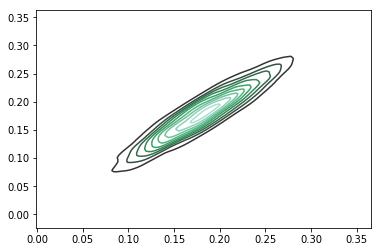

In [93]:
sns.kdeplot(samples[:,10,2,0], samples[:,11,2,0])
plt.show()

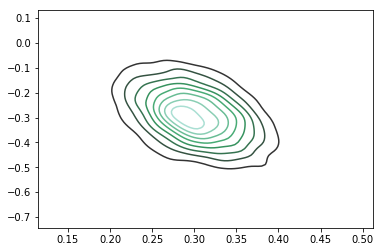

In [301]:
sns.kdeplot(samples[:,5,2,0], samples[:,5,0,0])
plt.show()

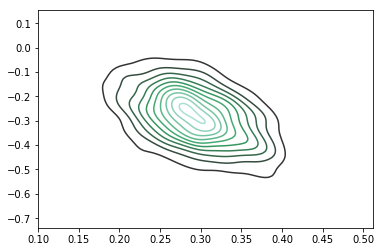

In [286]:
sns.kdeplot(samples[:,5,2,0], samples[:,5,0,0])
plt.show()

In [66]:
t = 14
# params[t]

In [67]:
np.mean(samples[:,t], axis=0)

array([[-0.0825,  0.0062, -0.1318, -0.0815],
       [ 0.0564,  0.1373,  0.5275,  0.036 ],
       [ 0.1206, -0.007 ,  0.9351,  0.2774]])

In [64]:
np.std(samples[:,t], axis=0)

array([[0.1049, 0.0981, 0.1117, 0.1097],
       [0.0974, 0.1036, 0.132 , 0.0985],
       [0.0473, 0.0392, 0.052 , 0.1675]])

In [163]:
np.mean(samples[:,t], axis=0)

array([[-0.2617, -0.0514, -0.1421, -1.1013],
       [ 0.0716,  0.1932,  0.6169,  0.2148],
       [ 0.2826, -0.0293,  0.8549,  0.9093]])

In [164]:
np.std(samples[:,t], axis=0)

array([[0.1349, 0.0932, 0.1238, 0.3107],
       [0.0814, 0.0982, 0.1407, 0.1506],
       [0.0623, 0.039 , 0.0645, 0.3178]])

In [278]:
from sklearn.neighbors.kde import KernelDensity
def score(s1, s2):
    bw = 0.1
    s1 = s1[:,np.newaxis]
    s2 = s2[:,np.newaxis]
    e1 = KernelDensity(bandwidth=bw).fit(s1)
    e2 = KernelDensity(bandwidth=bw).fit(s2)
    
    e1e2 = e1.score(s1) - e2.score(s1)
    e2e1 = e2.score(s2) - e1.score(s2)
    dist = (e1e2/len(s1) + e2e1/len(s2))/2
    return dist

In [271]:
def get_cdf(ts):
    return lambda x: (ts <= x).mean()
def score(s1,s2):
    c1 = get_cdf(s1)
    c2 = get_cdf(s2)

    m = 0
    for s in np.concatenate([s1, s2]):
        r = np.abs(c1(s) - c2(s))
        if r > m:
            m = r
    return m

In [203]:
score(s1,s2)

0.00014521624382734903

In [279]:
dists = []
for t1 in range(samples.shape[1] - 1):
    np.random.seed(1234)
    print(t1)
    t2 = t1 + 1
    s1 = samples[:,t1,0,0]
    s2 = samples[:,t2,0,0]
    ss = []
    for _ in range(10):
        s1_ = np.random.choice(s1, size=8000)
        s2_ = np.random.choice(s2, size=8000)
        m = score(s1_,s2_)
        ss.append(m)
    dists.append(ss)
dists = np.array(dists).T

0
1
2
3
4
6
7
8
9
10
11
12
13
14
15
16
17
18


## KDE + KL

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


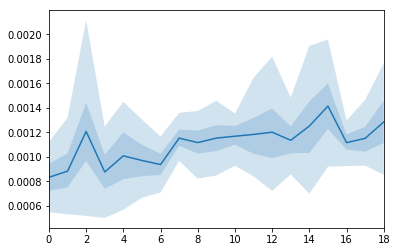

In [270]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


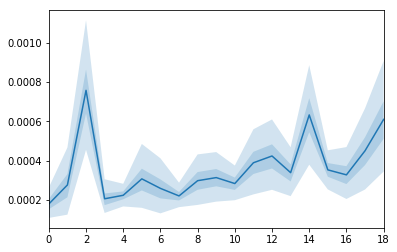

In [280]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

## Kolmogorov-Smirnov

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


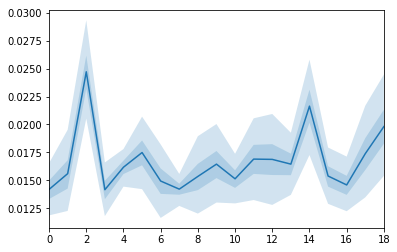

In [277]:
sns.tsplot(dists, ci=[50, 95])
plt.show()